<a href="https://colab.research.google.com/github/mlimbuu/pytorch-GAT/blob/main/pytorch_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SetUp Environment

In [ ]:
# !pip install torch==2.3.0
# !pip install networkx==3.3
# !pip install scipy==1.13.0
# !pip install numpy==1.26.4
# !pip install jupyter==1.0.0

# Import Libraries

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


import os
import glob
import time
import random
import argparse
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Data Loading & Preprocessing

In [2]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [3]:
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def load_data(path="./data/data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # normalize features and adjacency matrix
    features = normalize_features(features)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


In [4]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()


Loading cora dataset...


# GAT Layers

In [5]:

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


# GAT Model

In [6]:

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

# Model Traning

In [54]:
# Parameters
seed = 72
epochs = 1000
lr = 0.005
weight_decay = 5e-4
hidden = 8
nb_heads = 8
dropout = 0.6
alpha = 0.2
patience = 100

In [55]:
# Initialize model
model = GAT(nfeat=features.shape[1], nhid=hidden, nclass=int(labels.max()) + 1, dropout=dropout, nheads=nb_heads, alpha=alpha)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [56]:
# Training & Test

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val, acc_val, output

def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "accuracy= {:.4f}".format(acc_test.data.item()))


In [57]:
val_acc_list = []
val_loss_list = []

# Training model
for epoch in range(epochs):
    print(f"Training: {epoch}")
    val_loss, val_acc, out_features = train(epoch)
    print(f"loss_val:{val_loss}, val_acc:{val_acc}, out_features:{out_features}")
    # val_acc_list.append(val_acc.item())
    # val_loss_list.append(loss_val.item())
    val_loss_list.append(val_loss.item())
    val_acc_list.append(val_acc.item())


# Testing model
test()

Streaming output truncated to the last 5000 lines.
        [-7.9953e+00, -8.2567e+00, -7.5007e+00,  ..., -1.6302e-03,
         -8.7006e+00, -8.6908e+00],
        ...,
        [-4.5631e+00, -7.4365e-02, -5.0968e+00,  ..., -4.7995e+00,
         -3.6298e+00, -4.2223e+00],
        [-1.7941e-01, -4.2953e+00, -4.1590e+00,  ..., -2.9588e+00,
         -2.8283e+00, -4.3833e+00],
        [-4.7095e+00, -4.1338e+00, -5.4685e-02,  ..., -4.6098e+00,
         -4.9341e+00, -5.1261e+00]], grad_fn=<LogSoftmaxBackward0>)
Training: 609
Epoch: 0610 loss_train: 0.6513 acc_train: 0.7929 loss_val: 1.0761 acc_val: 0.6533 time: 4.2092s
loss_val:1.0760871171951294, val_acc:0.6533333333333333, out_features:tensor([[-7.8207e+00, -6.1204e+00, -5.3733e-03,  ..., -7.3589e+00,
         -7.6849e+00, -7.6438e+00],
        [-1.9459e+00, -1.9459e+00, -1.9459e+00,  ..., -1.9459e+00,
         -1.9459e+00, -1.9459e+00],
        [-6.6661e+00, -6.3673e+00, -6.7148e+00,  ..., -8.5098e-03,
         -6.1217e+00, -6.6813e+00],
   

# Visualization

In [58]:
# visualize learned feature representation
def visualize_learnedFeature_tSNE(labels, out_features, dataset):
    color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    if dataset =='citeseer':
        num_classes = 6
    elif dataset == 'cora':
        num_classes = 7
    elif dataset =='pubmed':
        num_classes = 3
    node_labels = labels.cpu().numpy()
    out_features = out_features.cpu().detach().numpy()
    t_sne_X = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_X[node_labels == class_id, 0],
                    t_sne_X[node_labels == class_id, 1], s=20,
                    color=color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("t-SNE projection of the learned features for "+dataset)
    plt.show()

# visulaize validation loss and accuracy
def visualize_validation_performance(val_acc, val_loss):
    f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
    ax[0].plot(val_loss, linewidth=2, color="red")
    ax[0].set_title("Validation loss")
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].grid()
    ax[1].plot(val_acc, linewidth=2, color="red")
    ax[1].set_title("Validation accuracy")
    ax[1].set_ylabel("Acc")
    ax[1].set_xlabel("Epoch")
    ax[1].grid()


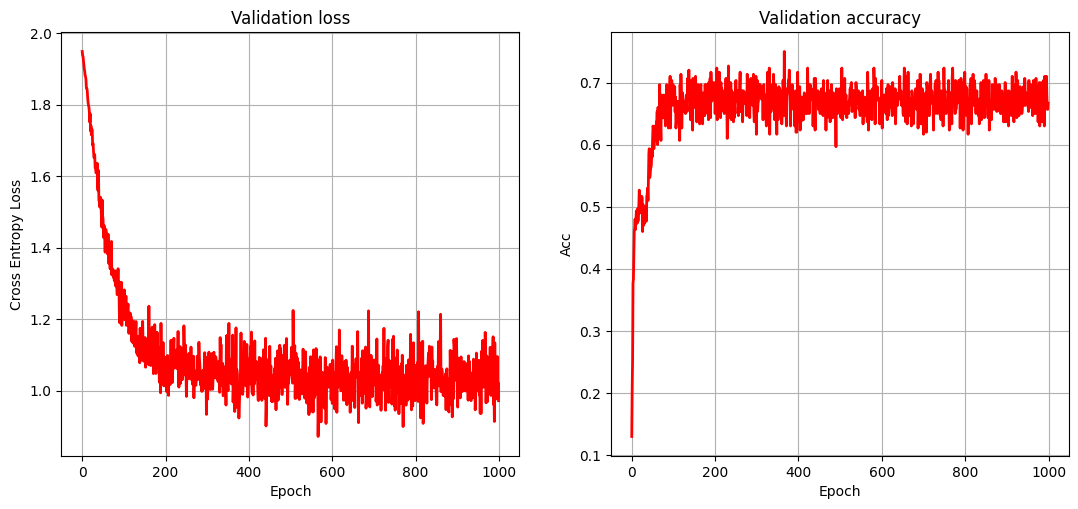

In [59]:
visualize_validation_performance(val_acc_list, val_loss_list)

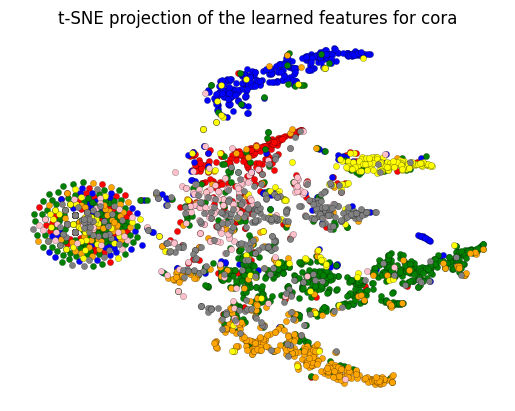

In [60]:
dataset = 'cora'

visualize_learnedFeature_tSNE(labels, out_features, dataset)